In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
from pprint import pprint

import re

from tqdm import tqdm_notebook

import scipy
from scipy import sparse
from scipy import stats

import pubchempy as pcp
from chembl_webresource_client.new_client import new_client 
import json
import requests

import copy

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole

import sys
sys.path.append("..")
import utils
import numpy as np

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [377]:
import json

class PubChemValidator(object):
    def __init__(self, targets_df, interaction_matrix, fps):
        self.tdf = targets_df
        self.interaction_matrix = interaction_matrix
        self.fps = fps

        self.ligands = {}
        self.targets = {}
        self.predictions = {}
    
    def load_checkpoint(self, ligs=True, targs=True, preds=True):
        self.ligands = json.load(open('ligands.json', 'r'))
        self.targets = json.load(open('targets.json', 'r'))
        self.predictions = json.load(open('predictions.json', 'r'))
        
#     def save_checkpoint(self, ligs=True, targs=True, preds=True):
#         if ligs:
#             with open('ligands.json', 'w') as fp:
#                 json.dump(self.ligands, fp)
#         if targs:
#             with open('targets.json', 'w') as fp:
#                 json.dump(self.targets, fp)
#         if preds:
#             with open('predictions.json', 'w') as fp:
#                 json.dump(self.predictions, fp)
            
    def has_ligand(self, idx):
        return str(idx) in self.ligands
    
    def has_target(self, idx):
        return str(idx) in self.targets

    def has_prediction(self, l_idx, t_idx):
        return str(l_idx)+':'+str(t_idx) in self.predictions
    
    def create_prediction(self, l_idx, t_idx, prob):
        record = dict()
        record['prob'] = str(prob)
        nn = self.get_nnrank_of_target(l_idx, t_idx)
        record['nn'] = nn
        
        self.predictions[str(l_idx)+':'+str(t_idx)] = record
        
    def create_target(self, idx):
        self.targets[str(idx)] = dict()
        record = self.targets[str(idx)]
    
        pref_name = self.tdf['pref_name'].iloc[idx]
        tid = self.tdf[self.tdf['pref_name']==pref_name]['chembl_id'].iloc[0]
        synonyms = get_synonyms(tid)
    
        record['pref_name'] = pref_name
        record['tid'] = tid
        record['synonyms'] = synonyms
        
    def create_ligand(self, idx):
        self.ligands[str(idx)] = dict()
        record = self.ligands[str(idx)]
    
        smi = smiles['canonical_smiles'].iloc[idx]
        chemblid = smiles['instance_id'].iloc[idx]
        cid = self.get_cid(smi)
        assays = self.get_assay_summary(cid)
        assays_parsed = self.parse_assays(assays)
    
        record['smi']=smi
        record['chemblid'] = chemblid
        record['cid'] = cid
        record['assays'] = assays_parsed
        
    def get_cid(self, smi):
        try:
            c = pcp.get_compounds(smi, 'smiles')[0]
            return c.cid
        except Exception as e:
            print(e)
            return 'cid_failed'
        
    def get_synonyms(self, tid):
        target = new_client.target
        res = target.filter(target_chembl_id=tid)
        synonyms = [i['component_synonym'] for i in res[0]['target_components'][0]['target_component_synonyms']]
        #clean:
        synonyms = [self.clean_text(i) for i in target_synonyms]
        return synonyms
    
    def clean_text(self, input_string):
        #source: https://stackoverflow.com/questions/34860982/replace-the-punctuation-with-whitespace
        #replace these with whitespace:
        clean_string = re.sub(r"""
               [(),.;@#?!&$]+  # Accept one or more copies of punctuation
               \ *           # plus zero or more copies of a space,
               """,
               " ",          # and replace it with a single space
               input_string.lower(), flags=re.VERBOSE)
    
        #replace these with nothing:
        clean_string = clean_string.replace('-', ' ')
        clean_string = clean_string.replace('=', '')
        return clean_string

    def get_assay_summary(self, cid):
        b = json.loads(requests.get('https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/cid/'+str(cid)+'/assaysummary/JSON').content)
        return b
    
    def parse_assays(self, assays):
        assays_parsed = []
        for assay in assays['Table']['Row']:
            cell = assay['Cell']
            aid = cell[0]
            name = self.clean_text(cell[11])
            activity = cell[6]
            
            assays_parsed.append([aid, activity, name])
        return assays_parsed
    
    def get_nnrank_of_target(self, ligand_idx, target_idx):
        
        positives = self.interaction_matrix[ligand_idx].nonzero()[1]
        all_distances = fast_jaccard(self.fps[ligand_idx], self.fps)[0]
        s = np.argsort(all_distances)
    
        pred = target_idx
        curr_rank = 0
        count=1
        preds = []
        seen = []

        while pred not in preds:
            predictions = self.interaction_matrix[s[count]].nonzero()[1]
    
            preds = np.setdiff1d(predictions,positives)
            preds = np.setdiff1d(preds, seen)
            seen += list(preds)
            curr_rank += 0 if len(preds)<1 else np.mean(np.arange(len(preds))+1)

            count+=1
        return curr_rank

In [378]:
pcv = PubChemValidator(None, None, None)

In [566]:
pcv.load_checkpoint()
print(len(pcv.predictions))

22049


In [567]:
# for pred in pcv.predictions.keys():
#     lig, targ = pred.split(':')
#     print(pcv.predictions[pred]['nn'])

In [568]:
import tqdm
import pandas as pd

df = pd.DataFrame(columns=['tid', 'pref_name', 'lig_chemblid', 'aid', 'outcome', 'title'])
count = 0 
acts = list()

inacts= list()
probs = list()
nns = list()
for pred in tqdm.tqdm_notebook(pcv.predictions.keys()):
    lig, targ = pred.split(':')
    try:
        target_synonyms = pcv.targets[targ]['synonyms']
        tid = pcv.targets[targ]['tid']
        pref_name = pcv.targets[targ]['pref_name']
        
        ligand_chemblid = pcv.ligands[lig]['chemblid']
    
        assays = pcv.ligands[lig]['assays']
    except:
        continue
        
    act = 0
    inact = 0
    unspec = 0
    
    
    for a in assays:
        aid = a[0]
        title = a[2]
        clean_title = pcv.clean_text(title)
        #print(target_synonyms, clean_title)
        num = len(set(target_synonyms).intersection(clean_title.split()))
        if num>0:
            outcome =  a[1]
            if outcome=='Unspecified':
                unspec+=1
            if outcome=='Active':
                #print(aid, clean_title, target_synonyms)
                act+=1
            if outcome=='Inactive':
                inact+=1
            if outcome in ['Active', 'Inactive']:
                df.loc[count] = [tid, pref_name, ligand_chemblid, aid, outcome, title]
                count+=1
    if sum([act, inact])>0:
        prob = pcv.predictions[pred]['prob']
        nn = pcv.predictions[pred]['nn']
        nns.append(nn)
        acts.append(act)
        inacts.append(inact)
        probs.append(float(prob))
        #print( act, inact, prob)#, unspec ) 
        
acts = np.array(acts)
inacts = np.array(inacts)
nns =np.array(nns)
probs = np.array(probs)

/Users/lmar3213/miniconda3/envs/lew_conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


In [569]:
df.sort_values(by='pref_name').to_csv('results.csv')

In [570]:
piv = df.pivot_table(index=['pref_name','lig_chemblid'], columns='outcome', aggfunc='size', fill_value=0)


In [571]:
n,x = np.histogram((piv['Active'] - piv['Inactive']).values, bins=100)

(-5.0, 5.0)

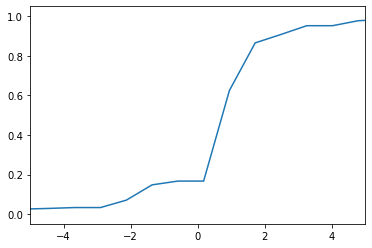

In [572]:
plt.plot(x[:-1], np.cumsum(n) / sum(n))
plt.xlim(-5,5)

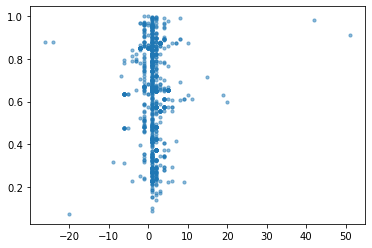

In [573]:
plt.scatter(np.array(acts) - np.array(inacts), 
            [float(i) for i in probs],
           s=10,
           alpha=0.5)

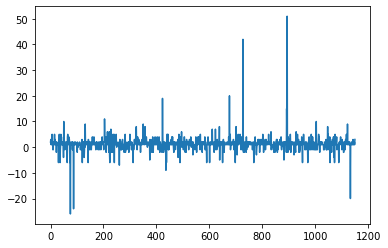

In [574]:
plt.plot(np.array(acts) - np.array(inacts))

In [575]:
d =np.vstack([np.array(acts),np.array(inacts)])

In [576]:
p = list()
n = list()
checks = np.arange(1,100)
for rank in checks:
    mask = nns>rank

    m = d.T[mask]
    res = (m[:,0] - m[:,1])

    
    p.append((res>0).sum())
    n.append((res<0).sum())
    print(f'RANK:{rank}')
    print('\t', (res>0).sum())
    print('\t',(res<0).sum())

RANK:1
	 566
	 140
RANK:2
	 275
	 129
RANK:3
	 204
	 126
RANK:4
	 173
	 122
RANK:5
	 154
	 117
RANK:6
	 138
	 110
RANK:7
	 134
	 104
RANK:8
	 118
	 103
RANK:9
	 107
	 102
RANK:10
	 96
	 100
RANK:11
	 91
	 98
RANK:12
	 81
	 95
RANK:13
	 76
	 92
RANK:14
	 70
	 92
RANK:15
	 67
	 89
RANK:16
	 63
	 89
RANK:17
	 59
	 89
RANK:18
	 59
	 89
RANK:19
	 56
	 87
RANK:20
	 53
	 87
RANK:21
	 53
	 85
RANK:22
	 52
	 84
RANK:23
	 50
	 82
RANK:24
	 49
	 82
RANK:25
	 48
	 81
RANK:26
	 43
	 79
RANK:27
	 43
	 78
RANK:28
	 40
	 78
RANK:29
	 40
	 78
RANK:30
	 40
	 78
RANK:31
	 38
	 78
RANK:32
	 38
	 77
RANK:33
	 37
	 77
RANK:34
	 36
	 76
RANK:35
	 36
	 75
RANK:36
	 34
	 73
RANK:37
	 32
	 73
RANK:38
	 31
	 71
RANK:39
	 31
	 68
RANK:40
	 31
	 66
RANK:41
	 30
	 66
RANK:42
	 30
	 65
RANK:43
	 30
	 65
RANK:44
	 28
	 63
RANK:45
	 27
	 63
RANK:46
	 26
	 60
RANK:47
	 25
	 58
RANK:48
	 24
	 57
RANK:49
	 24
	 57
RANK:50
	 22
	 56
RANK:51
	 22
	 55
RANK:52
	 21
	 54
RANK:53
	 20
	 53
RANK:54
	 19
	 51
RANK:55
	 19
	 50


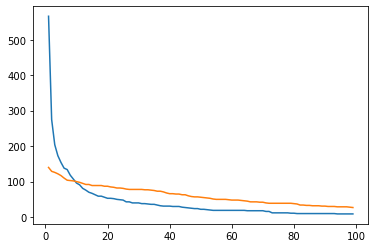

In [577]:
plt.plot(checks, p)
plt.plot(checks, n)

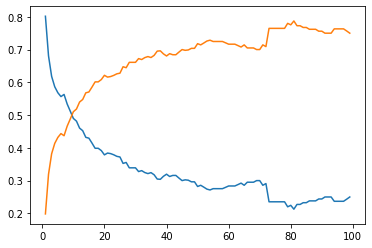

In [578]:
plt.plot(checks, 
         np.array(p) / (np.array(p)+np.array(n)))

plt.plot(checks, 
         np.array(n) / (np.array(p)+np.array(n)))

In [579]:
from scipy.stats import beta


Text(0.5, 0, 'Best ranking by similarity (1=easy, 10=hard, 20=very hard)')

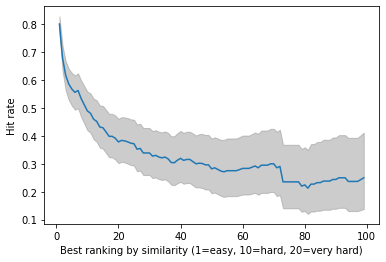

In [580]:

rate = np.array(p) / (np.array(p) + np.array(n))
low = beta.ppf(0.025, np.array(p)+1, np.array(n)+1)
high =beta.ppf(0.975, np.array(p)+1, np.array(n)+1)
plt.fill_between(x=checks,y1=low, y2=high,alpha=0.4, color='grey')
plt.plot(checks, rate)

plt.ylabel('Hit rate')
plt.xlabel('Best ranking by similarity (1=easy, 10=hard, 20=very hard)')


# #rate = np.array(n) / (np.array(p) + np.array(n))
# rate = 1-rate
# #low = beta.ppf(0.025, np.array(n)+1, np.array(p)+1)
# #high =beta.ppf(0.975, np.array(n)+1, np.array(p)+1)
# plt.fill_between(x=checks,y1=1-low, y2=1-high,alpha=0.4, color='grey')
# plt.plot(checks, rate)

# rate = np.array(p) / (np.array(p) + np.array(n))

<BarContainer object of 20 artists>

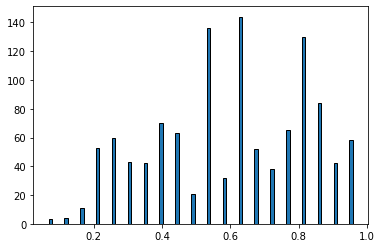

In [584]:
nbin = 20
n,x= np.histogram(probs,bins=nbin)
plt.bar(x[:-1], n,edgecolor='k', width=0.01)

0.6666666666666666 0.19412044968324338 0.932414013511457
1.0 0.4781762498950185 0.9949492366205319
1.0 0.7353515306029488 0.9978924067681397
0.9245283018867925 0.8210665708339272 0.969247214732477
1.0 0.9413187760677074 0.9995850400871603
0.8604651162790697 0.7264931090961761 0.9335565387971044
0.9285714285714286 0.8093927681142077 0.9740687097336765
1.0 0.9493705920455964 0.9996434747253966
0.7301587301587301 0.6091238708465891 0.8240336768839289
0.5714285714285714 0.36354696172973133 0.7561381340769835
0.9777777777777777 0.9368890738404673 0.9919293149927474
0.9375 0.797735687473645 0.9808450570125951
0.7816901408450704 0.7066301406671055 0.8416211581190569
0.9 0.7858550174543191 0.9555798581436852
0.8157894736842105 0.6646504388730692 0.9070360727170045
0.8 0.6867611541519059 0.878898067744857
0.6638655462184874 0.5748217121636484 0.7424456523481342
0.8658536585365854 0.775228259935659 0.9230009829455013
0.8536585365853658 0.7146061580867288 0.9302593363443249
0.7962962962962963 0.6

Text(0, 0.5, 'Hit rate')

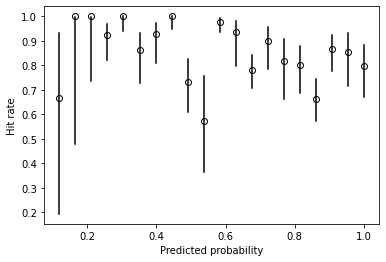

In [585]:
digits = np.digitize(probs,x)
for b in range(1,nbin+1):
    mask = digits==b
    
    pos = ((d[0] - d[1])>0)[mask].sum()
    neg = ((d[0] - d[1])<0)[mask].sum()
    
    low = beta.ppf(0.025, pos+1, neg+1)
    high = beta.ppf(0.975, pos+1, neg+1)
    print(pos/(pos+neg), low, high)
    
    plt.plot([ x[b], x[b]], [low, high], c='k')
    
    plt.scatter([x[b]], [pos/(pos+neg)],edgecolor = 'k', facecolor='white')
    
    
plt.xlabel('Predicted probability')
plt.ylabel('Hit rate')

In [546]:
low

0.01257911709342505

In [ ]:
plt.

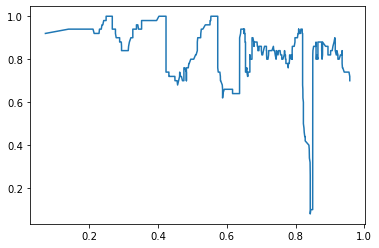

In [540]:
def moving_average(a, n=50) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

avgs = moving_average( ( d.T[np.argsort(probs)][:,0] - d.T[np.argsort(probs)][:,1]) > 0 ) 
pr = probs[np.argsort(probs)][:len(avgs)]

plt.plot(pr,avgs )

In [529]:
np.digitize(probs,x)==0

array([False, False, False, ..., False, False, False])

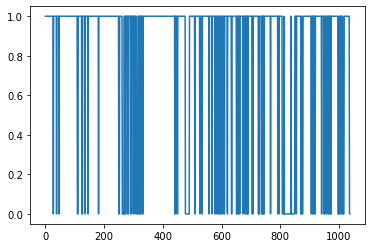

In [289]:
from seaborn import kdeplot
res = (d[0] - d[1])>0

plt.plot(res[np.argsort(probs)])

In [306]:
list((d[0] - d[1]) )

[2,
 3,
 1,
 3,
 1,
 2,
 5,
 1,
 1,
 -1,
 -1,
 2,
 1,
 2,
 1,
 5,
 1,
 3,
 2,
 2,
 1,
 2,
 -2,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 -6,
 1,
 2,
 5,
 1,
 1,
 -6,
 -1,
 1,
 5,
 1,
 4,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 -4,
 10,
 2,
 1,
 1,
 -1,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 1,
 -6,
 4,
 5,
 2,
 1,
 1,
 4,
 2,
 3,
 1,
 -6,
 1,
 -26,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 -1,
 2,
 -1,
 1,
 -24,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 0,
 -2,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 3,
 -6,
 0,
 1,
 1,
 2,
 1,
 2,
 -4,
 -1,
 1,
 0,
 9,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 1,
 2,
 -6,
 3,
 2,
 1,
 2,
 1,
 -1,
 -1,
 1,
 2,
 2,
 2,
 -1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 3,
 4,
 1,
 1,
 2,
 1,
 1,
 1,
 -1,
 0,
 2,
 0,
 2,
 2,
 1,
 1,
 1,
 -1,
 1,
 2,
 2,
 -1,
 1,
 1,
 2,
 1,
 2,
 -1,
 1,
 1,
 2,
 2,
 4,
 1,
 2,
 2,
 1,
 1,
 -1,
 2,
 2,
 11,
 5,
 2,
 4,
 2,
 1,
 -2,
 4,
 1,
 2,
 1,
 6,
 2,
 1,
 1,
 1,
 -2,
 3,
 6,
 -3,
 -6,
 2,
 -1,
 2,
 7,
 2,
 -2,
 1,
 2,
 2,
 2,
 -2,
 5,
 4,
 2,
 1,


In [303]:
list(np.sign(d[0] - d[1]))

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 -1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 0,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 -1,
 1,
 1,
 1,
 1,
 1,


In [291]:
res

array([ True,  True,  True, ...,  True,  True,  True])

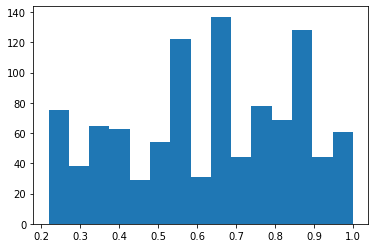

In [268]:
_ = plt.hist(probs,bins=15)

In [253]:
np.digitize(probs, x)

array([12, 17, 10, ...,  4, 12, 10])

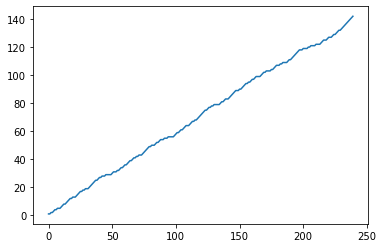

In [185]:
plt.plot(np.cumsum(m[:,0] > m[:,1]))

In [122]:
(np.array(acts)>0)

array([False, False,  True, ...,  True, False, False])

In [118]:
(np.array(inacts)==0)

array([ True,  True,  True, ..., False, False,  True])

In [99]:
lig, targ = pred.split(':')
    
target_synonyms = pcv.targets[targ]['synonyms']
    
assays = pcv.ligands[lig]['assays']

In [100]:
for count, a in enumerate(assays):
    title = a[2]
    clean_title = pcv.clean_text(title)
    #print(target_synonyms, clean_title)
    num = len(set(target_synonyms).intersection(clean_title.split()))
    if num>0:
        print( len(set(target_synonyms).intersection(clean_title.split())) )
        print(clean_title, count)

In [75]:
clean_title

'ncats parallel artificial membrane permeability assay  pampa profiling'

In [49]:
snms = pcv.targets[targ]['synonyms']


In [53]:
for a in pcv.ligands[lig]['assays']:
    title = a[2]
    clean_title = pcv.clean_text(title)
    print( len(set(snms).intersection(clean_title.split())) )

0
0
0


In [39]:
#take a random sample of assays across the (many) higher probability ones:
n = 400_000
take = 20000

weight = 1 / (np.arange(n)/take+1)
weight = weight/weight.sum()

sample = np.random.choice(n, take, p=weight, replace=False)

In [40]:
import matplotlib.pyplot as plt

# Update:

- **LDH paper.** draft done and on simuldocs. Lyndsey keen to submit by mid next week, I think this is easily doable given it's a pretty straightforward paper. I am leaning towards J. Nat. Prod.

- **Label correlation**. Re-ran all the pubchem validation stuff - Results are in! When you include all predictions, even those that would have been predicted highly by nearest neighbors, you get about an 80% hit rate. If you exclude the ones that were similar in structure anyway, indicating a prediction that is difficult to make with LBVS, then the hit rate reduces down to about 20% for the most dissimilar ligands. I think one in five is pretty good for dissimilar predictions!
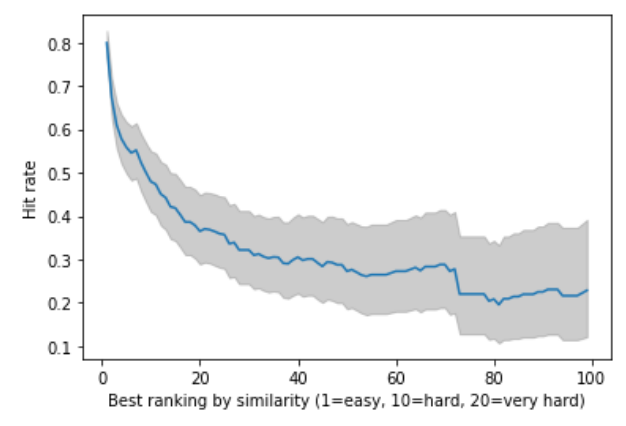

- **Cholesterol CBD**. No progress.